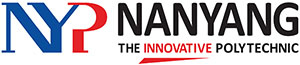

# IT3386 - AI Services in Analytics

## Part 1 - Data Preparation

This template contains some steps to help you complete your assignment. Refer to the assignment brief for details on the tasks you are required to perform and add them into the notebook accordingly.


## 1. Business Case

#### Introduction
Airport security is a critical component of global air travel, tasked with the responsibility of inspecting billions of pieces of luggage annually. The manual operation of X-ray screening systems is both monotonous and requires intense concentration, leading to significant miss rates for prohibited items. As air travel continues to grow, there is a pressing need for innovative solutions to enhance security measures while improving operational efficiency. 

To put the scale of the challenge into perspective:

- **Global Passenger Volume:** In 2019, global airports handled approximately 4.5 billion passengers, translating to around 6.75 billion pieces of luggage screened annually, assuming an average of 1.5 bags per passenger.
- **Carry-On Screening:** In 2022, the Transportation Security Administration (TSA) screened over 1.9 billion carry-on bags alone.

Given this vast volume, it is crucial to explore solutions that can automate the screening process. Human operators face several limitations:

- **Time Constraints:** Security officers have only 3-5 seconds on average to decide if a bag contains a threat.
- **Human Error:** Visual fatigue and monotony can lead to a miss rate of up to 20% for prohibited items.
- **Stress Factors:** The stressful nature of the job decreases concentration over time, increasing error rates.


#### Related Research

There have been several notable advancements in the field of AI-assisted baggage screening. Some of the key research efforts include:

1. **"Identify Harmful Objects in X-Ray Image of Baggages"** by Bajaj and Pandey (2021)  
   This study proposes an object detection algorithm using Faster R-CNN for X-ray baggage security screening images. It focuses on detecting dangerous items such as firearms and knives within X-ray images.

2. **"Efficient X-ray Security Images for Dangerous Goods Detection Based on Improved YOLOv7"** (2023)  
   This research presents a high-accuracy dangerous goods detection algorithm for X-ray security images, utilizing the YOLOv7 framework to improve detection speed and accuracy.

3. **"Can AI Detect Prohibited Items from Dual-view X-ray Images?"** (2023)  
   This paper introduces the Large-scale Dual-view X-ray (LDXray) dataset and proposes the Auxiliary-view Enhanced Network (AENet) to detect prohibited items using dual-view X-ray images, expanding the detection capabilities of AI-based systems.

While these solutions are valuable, no publicly available solutions which have explored the use of AutoML for building such systems. This proposal aims to fill that gap by investigating the potential of AutoML in developing AI models for airport security, democratizing access to advanced AI tools and making it easier for users with limited technical expertise to create such solutions.


#### Proposed Solution

We propose developing an AI object detection model tailored specifically to identify high-risk items in X-ray images of baggage. This solution will focus on detecting four of the most dangerous items that can cause serious harm:

- **Gun**
- **Blade**
- **Shuriken**
- **Knife**

By narrowing the focus to these high-risk items, the model can provide significant security enhancements while keeping implementation costs manageable. The use of AutoML will allow users to build, train, and deploy these models more easily, making this solution accessible to a wider range of airports, regardless of their technical capacity.


#### Benefits and Cost Savings
AI-assisted screening technology offers substantial benefits for airport security and operations. By improving detection accuracy by 70-90%, AI can significantly reduce missed threats, such as firearms, which have been increasingly found by the TSA. Key benefits include:

- **Increased Efficiency:** Automated screening can boost passenger throughput by 30-50%, allowing large airports to handle thousands more passengers daily without the need for additional staff.
- **Cost Savings:** Reduced false alarms can save up to $500,000 annually, while optimized staff usage may lead to labor cost reductions in the millions.
- **Time Savings:** Faster bag inspections can save over 40 hours per day for medium-sized airports, enhancing operational efficiency and increasing passenger satisfaction by up to 60%.
- **Enhanced Security:** AI models can improve detection accuracy, reducing the risk of security threats such as weapons and prohibited items entering airports. This also fosters better compliance with safety regulations, increasing passenger trust.
- **Business Case:** Improved security, increased operational efficiency, and significant cost savings make this a compelling business case for airports of all sizes. As AI technology continues to evolve, its benefits will likely increase, potentially revolutionizing airport security processes globally.

This approach has the potential to drive faster, more cost-effective deployments of security measures, ultimately enhancing safety, operational efficiency, and overall airport performance.

#### Conclusion

AI-driven X-ray image detection offers a promising solution to enhance airport security by improving threat detection, increasing operational efficiency, and reducing costs. By focusing on high-risk items such as guns, blades, and knives, and leveraging AutoML to make the technology accessible to more airports, we can significantly enhance security measures while streamlining operations. This approach not only makes airports safer but also provides substantial cost savings and efficiency gains, making it a valuable investment for airports worldwide.

## 2.1 Data Preparation

Main Tasks (refer to assignment brief for a complete list of tasks)
- Prepare images according to project criteria
- Perform image pre-processing
- Draw bounding boxes
- ...
- Prepare Annotation file
- Check bounding boxes of normalised vertices
- Ensure local directory contains images and annotation file

In [4]:
# %pip install roboflow
# %pip install python-dotenv

In [220]:
import os
import shutil
from pprint import pprint
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from roboflow import Roboflow
from dotenv import load_dotenv, find_dotenv
import warnings
from sklearn.utils import shuffle
import cv2


load_dotenv(find_dotenv())
warnings.filterwarnings("ignore")


RF_KEY = os.environ.get("ROBOFLOW_API_KEY")

In [16]:
def download_dataset(rf, project, version, download_format="voc"):
    download_path = os.path.join(os.getcwd(), "Threat-Detection-1")

    if os.path.exists(download_path):
        print(f"Dataset already exists at: {download_path}")
        return download_path

    print(f"Downloading dataset to {download_path}...")
    dataset = version.download(download_format)
    
    return dataset.location


rf = Roboflow(api_key=RF_KEY)
project = rf.workspace("gmrit").project("threat-detection-9yn3r")
version = project.version(1)

destination_path = download_dataset(rf, project, version)
destination_path

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Threat-Detection-1 in voc:: 100%|█| 5941/5941 


'/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1'

In [66]:
# create a dataframe with the filename + labels
# this is done for easier visualization and simplifies the process of keeping track of all the files

meta_df_cols = ['bag_id', 'file_path', 'split_label', 'object_label', 'coordinates_arr']
meta_df = pd.DataFrame(columns=meta_df_cols)
meta_df.head()

,bag_id,file_path,split_label,object_label,coordinates_arr


In [67]:
# since we downloaded the dataset in pascal VOC format, there is information of the object label and the bounding box in the XML files that we need to extract
# below is a function I created to parse the xml files and get this information out

def parse_voc_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = []
    
    for obj in root.findall('object'):
        label = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
        objects.append({
            "label": label,
            "bbox": [xmin, ymin, xmax, ymax]
        })
    
    return objects

In [116]:
data = []
for root, dirs, files in os.walk(destination_path):
    for file in files:
        if file.endswith('.xml'):
            file_path = os.path.join(root, file)
            bag_id = os.path.splitext(file)
            split_label = os.path.basename(root)

            jpg_file_path = os.path.join(root, f"{bag_id[0]}.jpg")
            objects = parse_voc_annotation(file_path)

            for obj in objects:
                data.append({
                    'bag_id': bag_id[0].split(".")[0][:-4],
                    'file_path': jpg_file_path,
                    'split_label': split_label,
                    'object_label': obj['label'],
                    'coordinates_arr': obj['bbox']
                })


meta_df = pd.DataFrame(data, columns=meta_df_cols)
meta_df.head()

,bag_id,file_path,split_label,object_label,coordinates_arr
0,BAG_0853,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/valid/BAG_0853_png.rf.716ea1cff9a7f02ccb079f7b176b3e03.jpg,valid,SHURIKEN,"[94, 313, 280, 543]"
1,BAG_0853,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/valid/BAG_0853_png.rf.716ea1cff9a7f02ccb079f7b176b3e03.jpg,valid,BLADE,"[380, 212, 432, 326]"
2,BAG_0107,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/valid/BAG_0107_png.rf.b4e49b50080ce7b603d9eb24f58a28e2.jpg,valid,GUN,"[269, 141, 520, 412]"
3,BAG_0427,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/valid/BAG_0427_png.rf.09c1cc0bd68817a2a9e0f40a49a8db15.jpg,valid,BLADE,"[206, 245, 263, 404]"
4,BAG_0779,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/valid/BAG_0779_png.rf.cb2944abe0ef85f6f75638ac3e80d835.jpg,valid,SHURIKEN,"[269, 76, 428, 271]"


In [153]:
meta_df = meta_df[~(meta_df['object_label'] == 'SCREW')]
meta_df.object_label.value_counts()

object_label
GUN         1779
BLADE       1603
SHURIKEN     690
KNIFE        163
Name: count, dtype: int64

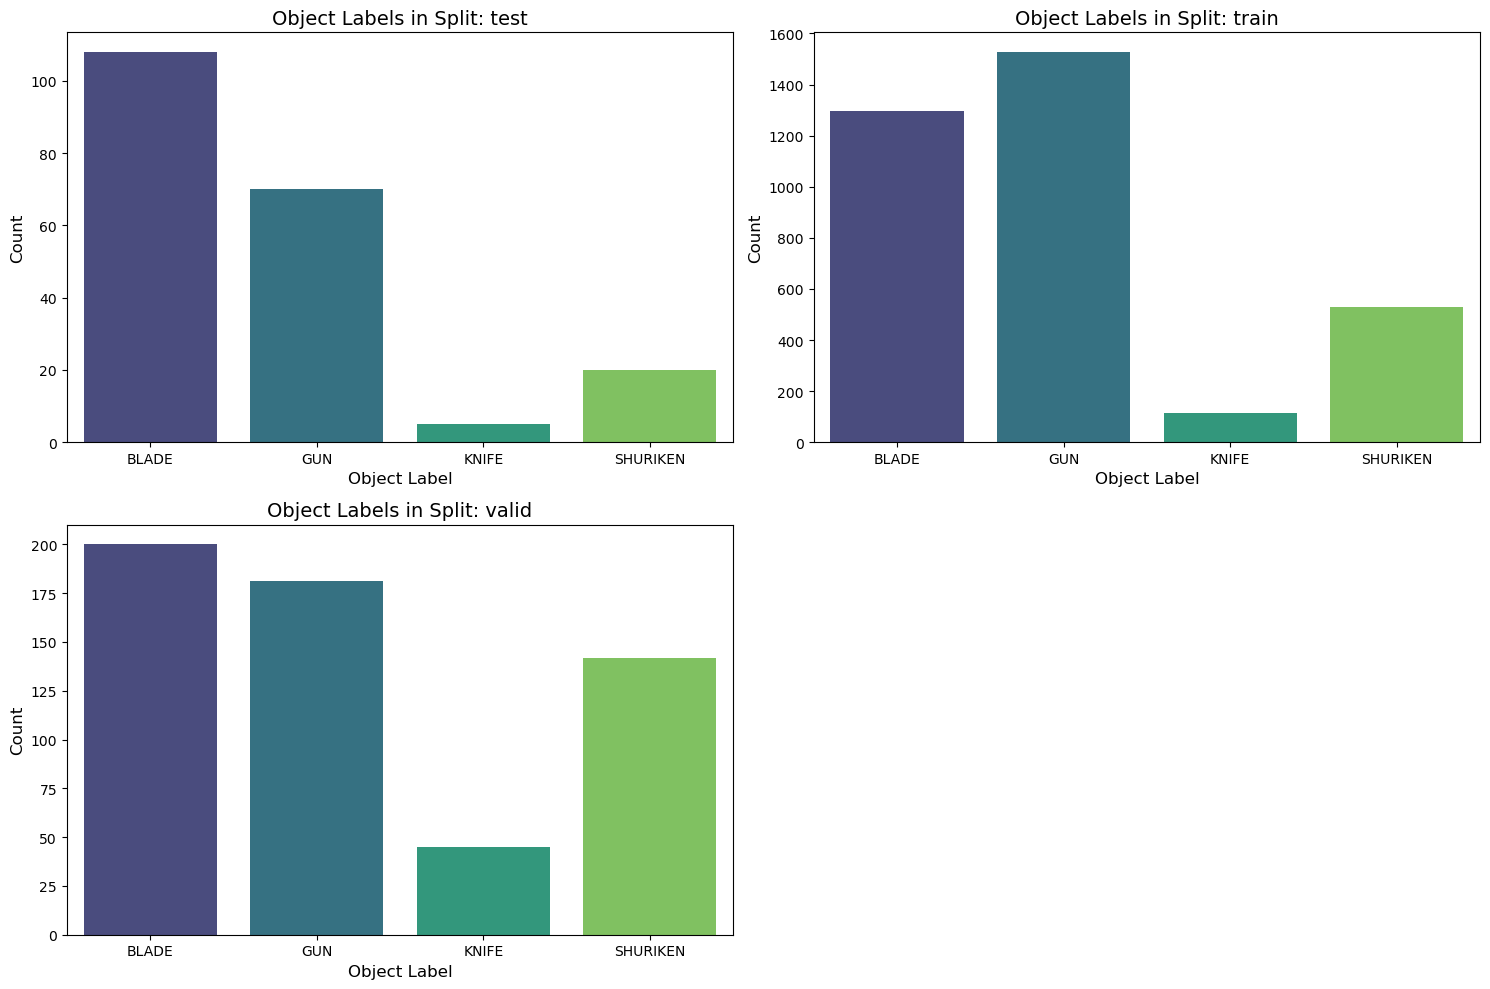

In [154]:
grouped_data = meta_df.groupby(['split_label', 'object_label']).size().reset_index(name='count')
split_labels = grouped_data['split_label'].unique()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(split_labels):
        split_data = grouped_data[grouped_data['split_label'] == split_labels[i]]
        sns.barplot(
            data=split_data,
            x='object_label',
            y='count',
            ax=ax,
            palette='viridis',
        )
        ax.set_title(f'Object Labels in Split: {split_labels[i]}', fontsize=14)
        ax.set_ylabel('Count', fontsize=12)
        ax.set_xlabel('Object Label', fontsize=12)
    else:
        ax.axis('off')

plt.tight_layout()

plt.show()

In [155]:
pd.set_option('display.max_colwidth', None)


meta_df.groupby("bag_id").count()

,file_path,split_label,object_label,coordinates_arr
bag_id,,,,
BAG_0001,6,6,6,6
BAG_0002,6,6,6,6
BAG_0003,4,4,4,4
BAG_0004,5,5,5,5
BAG_0005,6,6,6,6
...,...,...,...,...
BAG_1493,10,10,10,10
BAG_1494,5,5,5,5
BAG_1495,4,4,4,4


In [156]:
meta_df[meta_df["bag_id"] == "BAG_0001"]

,bag_id,file_path,split_label,object_label,coordinates_arr
1565,BAG_0001,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0001_png.rf.b5e7aba3b1d8f9ae223c6ab62c0daa08.jpg,train,BLADE,"[141, 296, 237, 382]"
1781,BAG_0001,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0001_png.rf.b6e6df5911c84777ba45d21f302ba746.jpg,train,BLADE,"[404, 293, 498, 388]"
2011,BAG_0001,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0001_png.rf.4f20bdbc3204f8c4ec928f6c7f8d3eae.jpg,train,BLADE,"[144, 293, 238, 388]"
2058,BAG_0001,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0001_png.rf.a91374404d122c2793f2331ec240cbeb.jpg,train,BLADE,"[144, 254, 238, 349]"
4424,BAG_0001,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0001_png.rf.f47cab41fa61d173d9e13a006ca9f062.jpg,train,BLADE,"[141, 261, 237, 347]"
4476,BAG_0001,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0001_png.rf.e5d34438a02759d78c1d395c99608f24.jpg,train,BLADE,"[405, 296, 501, 382]"


<div class="alert alert-info" role="alert">
From this it can be seen that each bag can have multiple images, further inspecting it its actually that the same bag shot at different angles. The bag itself has been rotated in a 3d space with the object being captured from all different angles along x, y and z axis.
    
<br>
<br>

This is good for us since we would not need to apply any kind of image augmentation steps since there are multiple variations of the image already (at least in terms of image repositioning, we can still augment based on color if required and when building a custom model, for the scope of this project it will be ignored).<br>

This means that the data set is quite diverse and will allow the model to generalize quite effectively. 
</div>

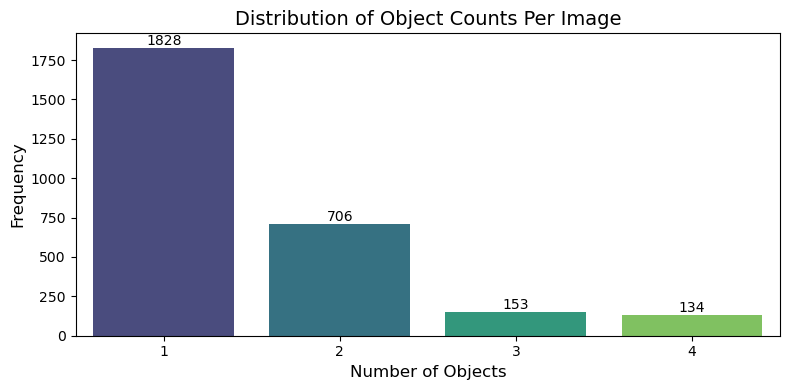

In [157]:
object_counts = meta_df.groupby('file_path').size().reset_index(name='object_count')
value_counts = object_counts['object_count'].value_counts()

plt.figure(figsize=(8, 4))
ax = sns.barplot(
    x=value_counts.index,
    y=value_counts.values,
    palette='viridis'
)

for i, value in enumerate(value_counts.values):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

plt.title('Distribution of Object Counts Per Image', fontsize=14)
plt.xlabel('Number of Objects', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert">
For training, it is best practice to have generally 1 - 2 images so that the model can easily differentiate between the multiple instances. <br><br>
Those images with 3 - 4 objects will be used for the testing dataset.
</div>

In [161]:
# I will make a new dataframe with the images that will be used for the trainining/validation and testing
# To make this, we can leverage the meta df that was created with all the image info + bounding boxes

# I will choose 70% of my training images to be 1 label and 30% to be of 2 labels
# To ensure that each class is equally represented, the labels will be picked as such. This prevents data imbalance

In [164]:
image_label_counts = meta_df.groupby('file_path')['object_label'].nunique().reset_index()
image_label_counts.columns = ['file_path', 'label_count']
filtered_images = image_label_counts[image_label_counts['label_count'] <= 2]['file_path']
filtered_images.head()

0    /Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/test/BAG_0035_png.rf.dbb2651d3c3160c6211c72ddbd09c827.jpg
1    /Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/test/BAG_0036_png.rf.f914ea86cd4c714e90efbc33f09c9fd5.jpg
2    /Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/test/BAG_0231_png.rf.03ce7e6a99a50310de296d862c597ea5.jpg
3    /Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/test/BAG_0433_png.rf.41544c78b4ec7ee4d75e3906c4ad31c8.jpg
4    /Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/test/BAG_0440_png.rf.4873b0cca6fd0d48c2143ae71998bc06.jpg
Name: file_path, dtype: object

In [172]:
filtered_meta_df = meta_df[meta_df['file_path'].isin(filtered_images)]

train_data = []
for label in filtered_meta_df['object_label'].unique():
    label_data = filtered_meta_df[filtered_meta_df['object_label'] == label]
    train_data.append(label_data.sample(n=50, random_state=42, replace=False))  # Ensure 50 bounding boxes per label

train_df = pd.concat(train_data).reset_index(drop=True).drop(columns=["split_label"])
train_df = shuffle(train_df, random_state=42)
print(train_df['object_label'].value_counts())
print(f"Total unique images in training set: {train_df['file_path'].nunique()}")

object_label
BLADE       50
SHURIKEN    50
KNIFE       50
GUN         50
Name: count, dtype: int64
Total unique images in training set: 184


In [174]:
train_df.head()

,bag_id,file_path,object_label,coordinates_arr
95,BAG_0438,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0438_png.rf.137741cb4c274cbc93e8a0037bdf74ef.jpg,BLADE,"[219, 235, 288, 374]"
15,BAG_0862,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/valid/BAG_0862_png.rf.18b53814d0b6090f43de2aa7b47b57a8.jpg,SHURIKEN,"[93, 314, 282, 545]"
30,BAG_0757,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0757_png.rf.96337e2339748f3c393f7caaee5b39cc.jpg,SHURIKEN,"[358, 315, 552, 549]"
158,BAG_0173,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/valid/BAG_0173_png.rf.8d61793a1f07427f369a3e854cf43eab.jpg,KNIFE,"[481, 115, 641, 603]"
128,BAG_1462,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_1462_png.rf.a4da556f05f5684c08949047efb15765.jpg,GUN,"[261, 159, 374, 235]"


In [216]:
remaining_meta_df = meta_df[~meta_df['file_path'].isin(train_df['file_path'])]

test_image_label_counts = remaining_meta_df.groupby('file_path')['object_label'].nunique().reset_index()
test_image_label_counts.columns = ['file_path', 'label_count']

test_filtered_images = test_image_label_counts[test_image_label_counts['label_count'] <= 4]

test_images = []
required_images = []

label_count_images = test_filtered_images[test_filtered_images['label_count'] == 3]
if not label_count_images.empty:
    required_images.append(label_count_images.sample(n=3, random_state=42)) 

remaining_needed = 10 - len(required_images)
for label_count in [1, 2]:
    if remaining_needed > 0:
        label_count_images = test_filtered_images[test_filtered_images['label_count'] == label_count]
        sample_count = min(remaining_needed, len(label_count_images))  
        test_images.append(label_count_images.sample(n=sample_count, random_state=42))
        remaining_needed -= sample_count

test_images = pd.concat(required_images + test_images)['file_path'].sample(n=10, random_state=42)
test_df = meta_df[meta_df['file_path'].isin(test_images)].reset_index(drop=True).drop(columns=["split_label"])

print(f"Total unique test images: {test_df['file_path'].nunique()}")
test_df

Total unique test images: 10


,bag_id,file_path,object_label,coordinates_arr
0,BAG_0834,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/valid/BAG_0834_png.rf.7ad02399c2b4f9a6b8a76634ce3e3457.jpg,GUN,"[309, 402, 449, 563]"
1,BAG_0834,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/valid/BAG_0834_png.rf.7ad02399c2b4f9a6b8a76634ce3e3457.jpg,GUN,"[102, 1, 317, 53]"
2,BAG_1043,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/test/BAG_1043_png.rf.eb73d80ec5d6b52130321f6aa8f5c0cc.jpg,SHURIKEN,"[220, 53, 394, 270]"
3,BAG_1043,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/test/BAG_1043_png.rf.eb73d80ec5d6b52130321f6aa8f5c0cc.jpg,GUN,"[184, 283, 473, 625]"
4,BAG_1043,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/test/BAG_1043_png.rf.eb73d80ec5d6b52130321f6aa8f5c0cc.jpg,KNIFE,"[399, 57, 474, 389]"
5,BAG_0211,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0211_png.rf.29b2d77c477f14cae8ed3ed0d66dd79b.jpg,GUN,"[91, 193, 275, 551]"
6,BAG_0226,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0226_png.rf.f8f9a1b93b5cfa4ceec10c3cd714ad9e.jpg,GUN,"[75, 132, 339, 436]"
7,BAG_1467,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_1467_png.rf.3e229f3b1bf4a7dc10457bad3777deaa.jpg,BLADE,"[333, 373, 426, 420]"
8,BAG_0708,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0708_png.rf.8d3c4fb70c355c7e73af309bbca6ef10.jpg,GUN,"[167, 17, 458, 359]"
9,BAG_0708,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0708_png.rf.8d3c4fb70c355c7e73af309bbca6ef10.jpg,SHURIKEN,"[256, 372, 429, 589]"


In [217]:
train_image_set = set(train_df['file_path'])
test_image_set = set(test_df['file_path'])

assert train_image_set.isdisjoint(test_image_set), "Train and Test images overlap!"

In [218]:
print(f"Training set: {len(train_df)} bounding boxes, {train_df['file_path'].nunique()} unique images, {train_df['file_path'].count()} total images.")
print(f"Test set: {len(test_df)} bounding boxes, {test_df['file_path'].nunique()} unique images, {test_df['file_path'].count()} total images.")

Training set: 200 bounding boxes, 184 unique images, 200 total images.
Test set: 19 bounding boxes, 10 unique images, 19 total images.


In [219]:
# image resizing
# resize bounding box
# normalize bounding box
# normalization of image
# contrast adjustment

In [257]:
def resize_image(image, target_size):
    original_size = image.shape[:2]
    if target_size[0] > original_size[1] or target_size[1] > original_size[0]:
        interpolation = cv2.INTER_CUBIC
    else:
        interpolation = cv2.INTER_AREA
    
    resized_image = cv2.resize(image, target_size, interpolation=interpolation)
    return resized_image
    
def resize_bounding_box(bbox, original_size, target_size):
    xmin, ymin, xmax, ymax = bbox
    original_width, original_height = original_size
    target_width, target_height = target_size

    new_xmin = xmin * target_width / original_width
    new_ymin = ymin * target_height / original_height
    new_xmax = xmax * target_width / original_width
    new_ymax = ymax * target_height / original_height

    new_bbox = (new_xmin, new_ymin, new_xmax, new_ymax)
    return new_bbox

def normalize_bounding_box(bbox, image_size):
    xmin, ymin, xmax, ymax = bbox
    width, height = image_size

    normalized_bbox = (xmin / width, ymin / height, xmax / width, ymax / height)
    return normalized_bbox

def normalize_image(image):
    normalized_image = image.astype(np.float32) / 255.0
    return normalized_image

def adjust_contrast(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gray)
    img_3ch = cv2.cvtColor(clahe_image, cv2.COLOR_GRAY2BGR)
    return img_3ch

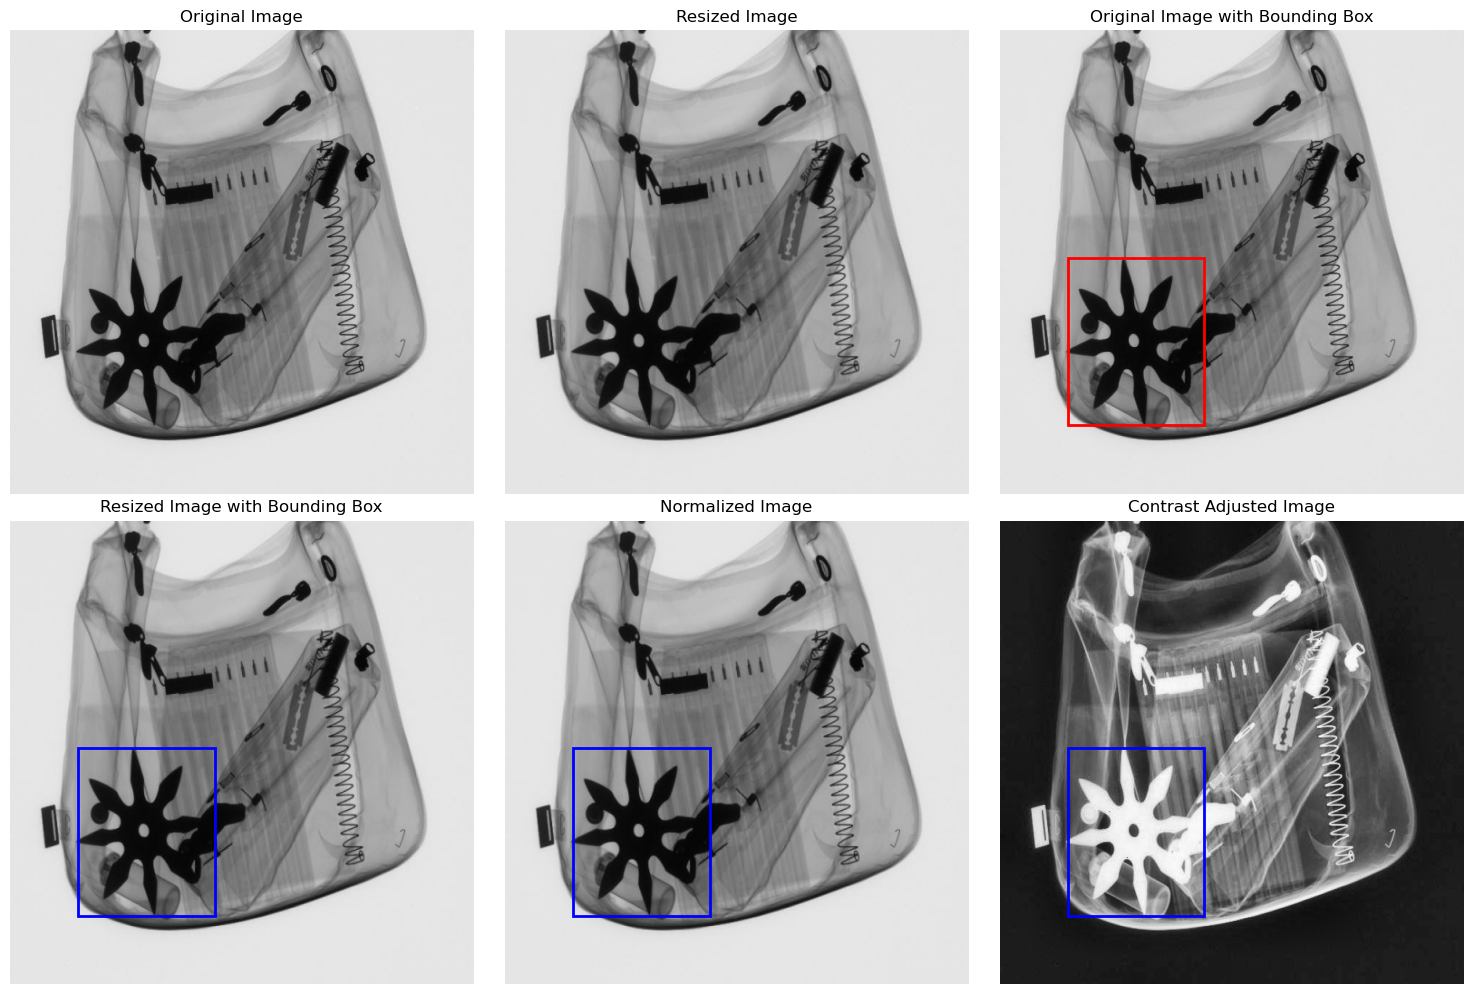

In [262]:
# Read the image
image = cv2.imread(train_df.iloc[1].file_path)
image_size = image.shape[:2]  # (height, width)

# 1. Resize image
target_size = (512, 512)
resized_image = resize_image(image, target_size)

# 2. Resize bounding box (example bbox: xmin, ymin, xmax, ymax)
# original_bbox = (50, 50, 200, 200)
original_bbox = train_df.iloc[1].coordinates_arr
resized_bbox = resize_bounding_box(original_bbox, image_size, target_size)

# 3. Normalize bounding box
normalized_bbox = normalize_bounding_box(resized_bbox, target_size)

# 4. Normalize image
normalized_image = normalize_image(resized_image)

# 5. Adjust contrast
contrast_image = adjust_contrast(image, clip_limit=2.0, tile_grid_size=(8, 8))

# Prepare the figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Display original image
axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title("Original Image")
axes[0, 0].axis('off')  # Hide axis

# Display resized image
axes[0, 1].imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title("Resized Image")
axes[0, 1].axis('off')  # Hide axis

# Display the image with bounding box (before and after resizing)
axes[0, 2].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0, 2].add_patch(plt.Rectangle((original_bbox[0], original_bbox[1]), 
                                   original_bbox[2] - original_bbox[0], 
                                   original_bbox[3] - original_bbox[1], 
                                   edgecolor='red', facecolor='none', linewidth=2))
axes[0, 2].set_title("Original Image with Bounding Box")
axes[0, 2].axis('off')  # Hide axis

# Display resized image with new bounding box
axes[1, 0].imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
axes[1, 0].add_patch(plt.Rectangle((resized_bbox[0], resized_bbox[1]), 
                                   resized_bbox[2] - resized_bbox[0], 
                                   resized_bbox[3] - resized_bbox[1], 
                                   edgecolor='blue', facecolor='none', linewidth=2))
axes[1, 0].set_title("Resized Image with Bounding Box")
axes[1, 0].axis('off')  # Hide axis

# Display normalized image
axes[1, 1].imshow(cv2.cvtColor((normalized_image * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
axes[1, 1].set_title("Normalized Image")
axes[1, 1].add_patch(plt.Rectangle((resized_bbox[0], resized_bbox[1]), 
                                   resized_bbox[2] - resized_bbox[0], 
                                   resized_bbox[3] - resized_bbox[1], 
                                   edgecolor='blue', facecolor='none', linewidth=2))
axes[1, 1].axis('off')  # Hide axis

# Display contrast-adjusted image
contrast_bbox = [
    resized_bbox[0] * (contrast_image.shape[1] / normalized_image.shape[1]),
    resized_bbox[1] * (contrast_image.shape[0] / normalized_image.shape[0]),
    resized_bbox[2] * (contrast_image.shape[1] / normalized_image.shape[1]),
    resized_bbox[3] * (contrast_image.shape[0] / normalized_image.shape[0])
]

# Display contrast-adjusted image
axes[1, 2].imshow(cv2.cvtColor((contrast_image * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
axes[1, 2].add_patch(plt.Rectangle((contrast_bbox[0], contrast_bbox[1]), 
                                   contrast_bbox[2] - contrast_bbox[0], 
                                   contrast_bbox[3] - contrast_bbox[1], 
                                   edgecolor='blue', facecolor='none', linewidth=2))
axes[1, 2].set_title("Contrast Adjusted Image")
axes[1, 2].axis('off')  # Hide axis

# Adjust layout and show
plt.tight_layout()
plt.show()

## 2.2 Google Cloud Storage


Ensure the following are installed in your local environment:
- The Google Cloud SDK (refer to Practical 2_2)
- Execute the following command to set up your Conda environment before proceeding
    - <code>conda install -c conda-forge google-cloud-aiplatform google-cloud-storage</code>
    
Refer to the assignment brief on where you can obtain your 
1. project_id (contains your admin number, ending with **small** cap letter)
2. service_account
3. service_account_key.json

In [ ]:
PROJECT_ID = ???

In [ ]:
# do not change
REGION = "us-central1"

### Cloud Storage bucket

When you initialize the Vertex AI SDK for Python, you specify a Cloud Storage staging bucket. The staging bucket is where all the data associated with your dataset and model resources are retained across sessions.

The name of your Cloud Storage bucket is set below. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.

In [ ]:
# do not change
BUCKET_NAME = PROJECT_ID + "-3386-aip"
BUCKET_URI = f"gs://{BUCKET_NAME}"

In [ ]:
print(BUCKET_URI)

Set up ADC to use your service account. Refer to Practical 7 for details on Google Cloud Storage setup and how to upload your images and annotation file.

### Final check on annotation file

Inside your annotation file, every image is specified as a Cloud Storage resource path (e.g. gs://project-id/masks/123.jpg).

> Verify each resource path is valid.

Common errors:
1. Do not use spaces; use an underscore or a dash
<pre>✘ gs://s2-123456a-aip-3386/masks/image<span style="background-color: #FFFF00"> </span>1.jpg</pre>
<pre>✔ gs://s2-123456a-aip-3386/masks/image<span style="background-color: #FFFF00">_</span>1.jpg</pre>

2. Last character of project id with your admin number is small cap
<pre>✘ gs://s2-123456<span style="background-color: #FFFF00">A</span>-aip-3386/masks/baseball/1.jpg</pre>
<pre>✔ gs://s2-123456<span style="background-color: #FFFF00">a</span>-aip-3386/masks/baseball/1.jpg</pre>